In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Relaxation

A second-order accurate discretization of the second derivative is:

$$\phi_i^{\prime\prime} = \frac{\phi_{i+1} - 2\phi_i + \phi_{i-1}}{\Delta x^2}$$

This is true on finite-difference and finite-volume grids (to second-order in $\Delta x$).  

We'll work in 1-d.  Our 
Poisson equation

$$\phi^{\prime\prime} = f$$

becomes:

$$\frac{\phi_{i+1} - 2\phi_i + \phi_{i-1}}{\Delta x^2} = f_i$$



Using this discretization for all zones i in $0, \ldots, N-1$ results in $N$ coupled algebraic equations.

We can solve for the update for a single zone:

$$\phi_i = \frac{1}{2} ( \phi_{i+1} + \phi_{i-1} - \Delta x^2 f_i ) $$


We could solve this by writing it as a linear system, $Ax = b$, with $A$ a triadiagonal matrix with diagonals $1, -2, 1$ and $b$ corresponding to $f_i$.  This approach is a "direct solve" of the coupled system.  But this can be expensive in multi-dimensions and harder to parallelize if domain decomposition is used.

Instead of directly solving the linear system, we can use relaxation&mdash;an iterative approach that converges to the solution.  Generally relaxation requires that the matrix be *diagonally dominant*, which we are just shy of, but nevertheless, relaxation works quite well for this system.  There are two popular approaches we can consider:

* *Jacobi iteration* :
  * pick an initial guess $\phi_i^{(0)}$ for all $i$
  * Improve the guess via relaxation:

    $$\phi_i^{(k+1)} = \frac{1}{2} ( \phi_{i+1}^{(k)} + \phi_{i-1}^{(k)} - \Delta x^2 f_i )$$
    
  * Assess the error, and if needed iterate
  
* *Gauss-Seidel (G-S) iteration* :

  * pick an initial guess $\phi_i^{(0)}$ for all $i$

  * use the new data as it becomes available:
  
    $$\phi_i \leftarrow \frac{1}{2} ( \phi_{i+1} + \phi_{i-1} - \Delta x^2 f_i )$$
  
    Note that there are no iteration superscripts indicated here, since we are not keeping the old and new $\phi$ separate in memory.
    We keep only a single $\phi$ and update it as we sweep from $i = 0, \ldots, N-1$.

A variation on G-S iteration is red-black Gauss-Seidel (think of a checkerboard).

* First update the odd points&mdash;they only depend on the values at the even points
* Next update the even points&mdash;they only depend on the values of the odd points

The advantage of this is that it makes it much easier to parallelize via domain decomposition.  We'll use this approach going forward.

## Boundary Conditions

We need to pay special attention to the boundaries.  This depends on what type of grid we are using.

For a finite difference (node-centered) grid:

![finite-difference grid](fd_grid_bnd.png)

we have a point exactly on each boundary, so we only need to iterate over the interior points.

In contracts, for a finite-volume or cell-centered finite-difference grid:

![finite-volume grid](ccfd_grid_bnd.png)

we don't have data on the physical boundaries, so we will need to interpolate to the boundary.

We'll work with a cell-centered grid, with a single ghost cell (needed to set the boundary conditions).  We'll label the first interior zone as `lo` and the last interior zone as `hi`.  Imagine that the domain runs from $[a, b]$.

![cell-centered finite difference grid with labels](ccfd_ghost.png)

Consider the following boundary conditions:

* Dirichlet: we need the value on the boundary itself to satisfy the boundary condition:

  $$\phi(a) = A$$
  
  A naive guess would be to set $\phi_{\mathrm{lo}-1} = A$, but this is only first order accurate.
  
  Instead we recognize that we can average across the boundary to be second-onder on the boundary:
  
  $$A = \frac{\phi_\mathrm{lo} + \phi_\mathrm{lo-1}}{2}$$
  
  which gives the ghost cell value:
  
  $$\phi_{\mathrm{lo}-1} = 2 A - \phi_\mathrm{lo}$$
  
  
* Neumann: we need a gradient, centered at the boundary to match the given value:

  $$\phi^\prime(a) = C$$
  
  A second-order accurate discretization one the boundary is:
  
  $$C = \frac{\phi_\mathrm{lo} - \phi_\mathrm{lo-1}}{\Delta x}$$
  
  so we would initialize the ghost cell as:
  
  $$\phi_{\mathrm{lo}-1} = \phi_\mathrm{lo} -\Delta x C$$
  
  
  
  

## First implementation


Let's start by writing a grid class that holds the solution and RHS and knows how to fill ghost cells.

In [25]:
class Grid:
    def __init__(self, nx, ng=1, xmin=0, xmax=1,
                 bc_left_type="dirichlet", bc_left_val=0.0,
                 bc_right_type="dirichlet", bc_right_val=0.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx
        
        self.bc_left_type = bc_left_type
        self.bc_left_val = bc_left_val
        
        self.bc_right_type = bc_right_type
        self.bc_right_val = bc_right_val
        
        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.phi = self.scratch_array()
        self.f = self.scratch_array()
        
    def scratch_array(self):
        """return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_bcs(self):
        """fill the boundary conditions on phi"""
        
        # we only deal with a single ghost cell here
        
        # left
        if self.bc_left_type.lower() == "dirichlet":
            self.phi[self.ilo-1] = 2 * self.bc_left_val - self.phi[self.ilo]
        elif self.bc_left_type.lower() == "neumann":
            self.phi[self.ilo-1] = self.phi[self.ilo] - self.dx * self.bc_left_val
        else:
            raise ValueError("invalid bc_left_type")
            
        # right
        if self.bc_right_type.lower() == "dirichlet":
            self.phi[self.ihi+1] = 2 * self.bc_right_val - self.phi[self.ihi]
        elif self.bc_right_type.lower() == "neumann":
            self.phi[self.ihi+1] = self.phi[self.ihi] - self.dx * self.bc_right_val
        else:
            raise ValueError("invalid bc_right_type")
        

Next we'll write a smoother routine, that does a single pass of red-black G-S

In [41]:
def smooth(g):
    """perform red-black Gauss-Seidel smoothing"""
    
    g.fill_bcs()
    
    g.phi[g.ilo:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo:g.ihi+1:2] +
                                    g.phi[g.ilo+1:g.ihi+2:2] + g.phi[g.ilo-1:g.ihi:2])
    
    g.fill_bcs()

    g.phi[g.ilo+1:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo+1:g.ihi+1:2] +
                                      g.phi[g.ilo+2:g.ihi+2:2] + g.phi[g.ilo:g.ihi:2])

Now we are ready to try this out.  Let's do the problem:

$$\phi^{\prime\prime} = \sin(x)$$

on $[0, 1]$ with homogeneous Dirichlet BCs.

The solution is:

$$\phi(x) = -\sin(x) + x \sin(1)$$

Let's create functions that initialize the RHS and the analytic solution.

In [42]:
def analytic(x):
    return -np.sin(x) + x * np.sin(1.0)

def f(x):
    return np.sin(x)

Now let's create the grid&mdash;we'll use 128 points to start.  The defaults for the grid class already set homogeneous Dirichlet BCs.

In [43]:
g = Grid(128)

Now we need to initialize $\phi$ and $f$.  For $\phi$, we may as well just initialize it to $0$ (which is already done for us by the grid class), since usually we don't know what the answer is.

In [44]:
g.f[:] = f(g.x)

Now we can do relaxation / smoothing.  We don't know how many smoothing iterations we need, and we also haven't yet discussed how to determine what the error is / when to stop.  So we'll look at the result after a fixed number of smoothing iterations.

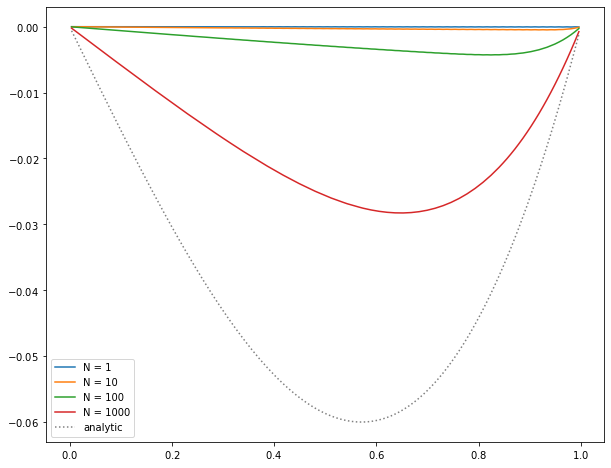

In [48]:
fig = plt.figure()
fig.set_size_inches(10,8)
ax = fig.add_subplot(111)

niters = [1, 10, 100, 1000]

for n in niters:

    # smooth n times
    for _ in range(n):
        smooth(g)
    
    ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1], label=f"N = {n}")
    
    # reset phi to 0 for the next number of iterations
    g.phi[:] = 0.0

ax.plot(g.x[g.ilo:g.ihi+1], analytic(g.x[g.ilo:g.ihi+1]), ls=":",
        color="0.5", label="analytic")

ax.legend()

We see that as we increase the number of smoothing iterations, we get closer to the analytic solution.  Also note that the solution appears to be respecting our boundary conditions well.

However, even after 1000 smoothing iterations, we are still far from the true solution.

<div class="alert alert-block alert-info">

**Exercise:**
    
Code up Jacobi relaxation and see how it compares to G-S on this problem.
</div>